# Finite Time Lyapunov Exponent (FTLE) method tutorial

Rough Steps:
1. Gather flow field data 
2. Initialize particles into flow field
3. Calculate velocities of the particles at the initial time
4. Integrate the velocities in time over interval T
- use bilinear interpolation to calculate velocities
- use runge-kutta 4th order method to propagate particles
5. Evaluate deformation tensor 
6. Create Cauchy-Green strain tensor
7. Calculate the expansion coefficient
8. Calculate FTLE field 
9. Repeat previous steps but integrate backwards in time
10. Post-process in order to get the saddle points

## Step 1. Gather flow field data
This notebook will use the flow field data from a pitching airfoil case. We will solve for the positive and negative FTLE (pFTLE, nFTLE) in addition to the saddle points. 

In [1]:
using FileIO, ImageMagick, Colors, FixedPointNumbers, DelimitedFiles, PyPlot, LinearAlgebra, HDF5
print("DONE")

DONE

<div class="alert alert-block alert-warning">  
<b> If error:</b> Run the code below 
</div>

In [3]:
#=
import Pkg
Pkg.add("FileIO")
Pkg.add("ImageMagick")
Pkg.add("Colors")
Pkg.add("FixedPointNumbers")
Pkg.add("DelimitedFiles")
Pkg.add("PyPlot")
Pkg.add("LinearAlgebra")
Pkg.add("HDF5")
=#

In [ ]:
fname = "FTLE.h"
fid = h5open(fname, "cw")
# close(fid)
create_group(fid, "Input Data")
inputData = fid["Input Data"]
inputData["xR"] = x_range

h5open(fname, "w") do fid
    g = create_group(fid, "input_data")
    dset = create_dataset(g, "xy_range", Float64, (10,))
    write(dset,rand(10))
end

First we have to get the flow field data. For this tutorial, we will be using Dr. Karthik Menon's data about a pitching airfoil demonstrating unsteadiness and dynamic stall. 
In addition to the flow field data, the airfoil coordinates, and vorticity will also be used for visualization later.

In [2]:
current = pwd()

"c:\\Users\\justi\\Documents\\GitHub\\FTLE_JJ"

Make sure that the physical data is stored locally and follows the file path. 

In [3]:
data = joinpath(current, "data") 
data_saved =  joinpath(current, "data_saved") 
name =  "xR2.h"
x_range = h5open(joinpath(data,name), "r") do file
    read(file, "A")
end
name =  "yR2.h"
y_range = h5open(joinpath(data,name), "r") do file
    read(file, "A")
end
name = "VelData2.h"
Vel_contour = h5open(joinpath(data,name), "r") do file
    read(file, "A")
end
name =  "BvoData2.h"
Bvo_contour = h5open(joinpath(data,name), "r") do file
    read(file, "A")
end
num_tsteps = size(Vel_contour)[2]
print("DONE")

DONE

In [4]:
og_num_tsteps = Int64((150000-200)/200 + 1)
inter = 2
tsteps = (og_num_tsteps-1)*inter+1
tstep_range = collect(range(200/1000, 150000/1000, length=tsteps))
print("DONE")

DONE

Afterwards, intialize the flow field with a grid of particles. The amount of particles can be more than the resolution of the flow field, as the velocities of these particles can be interpolated. 
Additionally, flow fields can also be interpolated between two flow fields with the smallest timestep.

In [7]:
t0 = 63800/1000
dt = 9000/1000
t1 = t0 + dt
move = Int64(sign(t1-t0))
t0_ind = Int64(argmin(abs.(tstep_range .- t0)))
t1_ind = Int64(argmin(abs.(tstep_range .- t1)))
tsteps = Int64(round(abs(t1 - t0)/(100/1000) + 1))

nx = 300
ny = 300
x0, x1, y0, y1 = 9.5,12.0,9.0,11.0
x = collect(range(x0, x1, length=nx))
y = collect(range(y0, y1, length=ny))
particles = zeros(3, tsteps+1, nx, ny)
for tt in 1:tsteps
    for ii in 1:nx
        for jj in 1:ny
            # Initialize the particles into the flow field
            particles[1,tt,ii,jj] = x[ii]
            particles[2,tt,ii,jj] = y[jj]
        end
    end
end
print("DONE")

DONE

The particles are then advected/integrated with the flow from a prescribed initial and final time. The advection can go both in increasing and decreasing time. 
For demonstration, we will first propagate the particles forward in time with a total integration time of around 2 periods. 
The velocity of the points in the flowfield at each timestep will be interpolated using bilinear interpolation. 
A Runge-Kutta 4th order method will be used for time step integration.

In [8]:
function find_me(xval, yval)
    x1 = argmin(abs.(x_range .- xval))
    y1 = argmin(abs.(y_range .- yval))

    if x1 >= size(x_range)[1]-1
        x1 -= 3
    end
    
    if y1 >= size(y_range)[1]-1
        y1 -= 3
    end

    x2 = x1 + 1
    y2 = y1 + 1

    # x1 = min(argmin(abs.(x_range .- xval)),size(x_range)[1]-1)
    # y1 = min(argmin(abs.(y_range .- yval)),size(y_range)[1]-1)

    return x1, x2, y1, y2
end

find_me (generic function with 1 method)

In [9]:
x = x_range
y = y_range
tstep_delta = 100/1000
# Integrate using Runge-Kutta 4th Order Method
for tt in t0_ind:move:t1_ind
    for ii in 1:nx
        for jj in 1:ny
            # Let's use Runge Kutta 4th order
            kxy = zeros(4,2)
            a = particles[1,Int64(move*(tt-t0_ind)+1),ii,jj]
            b = particles[2,Int64(move*(tt-t0_ind)+1),ii,jj]
            #=Runge Kutta 4th Order K1 =#
            c = copy(a)
            d = copy(b)
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[1,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt,y1,x1] + 
                            (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt,y2,x1] +
                            (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt,y1,x2] +
                            (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt,y2,x2] )
            end
            #=Runge Kutta 4th Order K2 =#
            c = a + 0.5*kxy[1,1]*tstep_delta
            d = b + 0.5*kxy[1,2]*tstep_delta
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[2,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                            (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                            (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                            (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
            end
            #=Runge Kutta 4th Order K3 =#
            c = a + 0.5*kxy[2,1]*tstep_delta
            d = b + 0.5*kxy[2,2]*tstep_delta
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[3,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                            (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                            (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                            (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
            end
            #=Runge Kutta 4th Order K4 =#
            c = a + kxy[3,1]*tstep_delta
            d = b + kxy[3,2]*tstep_delta
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[4,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt+move,y1,x1] + 
                            (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt+move,y2,x1] +
                            (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt+move,y1,x2] +
                            (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt+move,y2,x2] )
            end
            for UV in 1:2
                particles[UV,Int64(move*(tt-t0_ind)+2),ii,jj] = particles[UV,Int64(move*(tt-t0_ind)+1),ii,jj] + sign(move)*(kxy[1,UV]+2*kxy[2,UV]+2*kxy[3,UV]+kxy[4,UV])*tstep_delta/6
            end
        end
    end
end
print("DONE")

DONE

Before we go to calculating FTLE values, let's plot some flowmaps first that maps what the new coordinates of the particles are now based on its initial value.

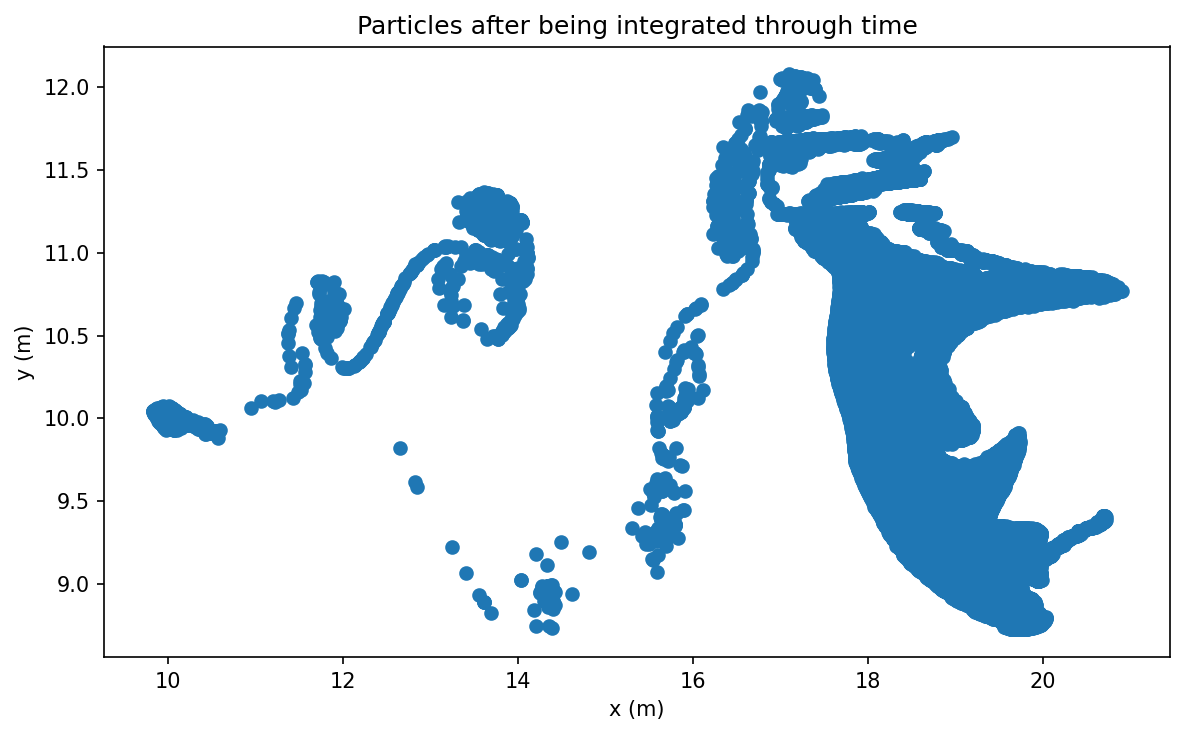

In [10]:
fig, ax = subplots(figsize=(8,5), dpi=150)
ax.scatter(particles[1,end,:,:],particles[2,end,:,:])
ax.set_title("Particles after being integrated through time")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

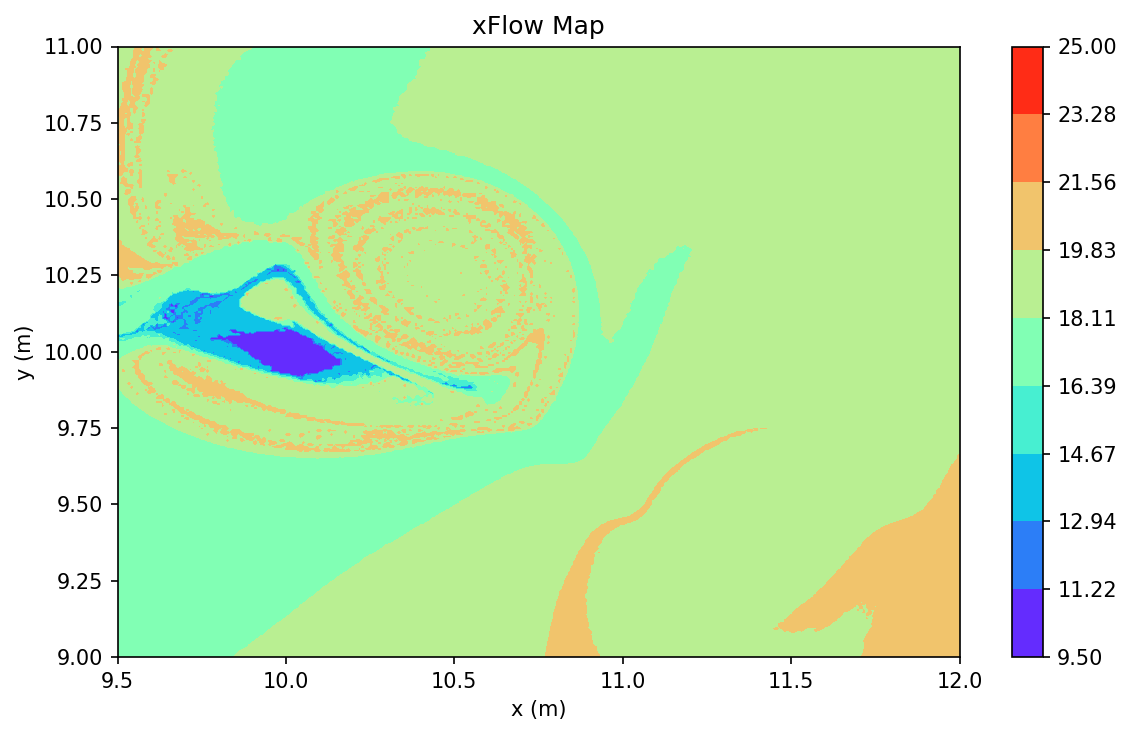

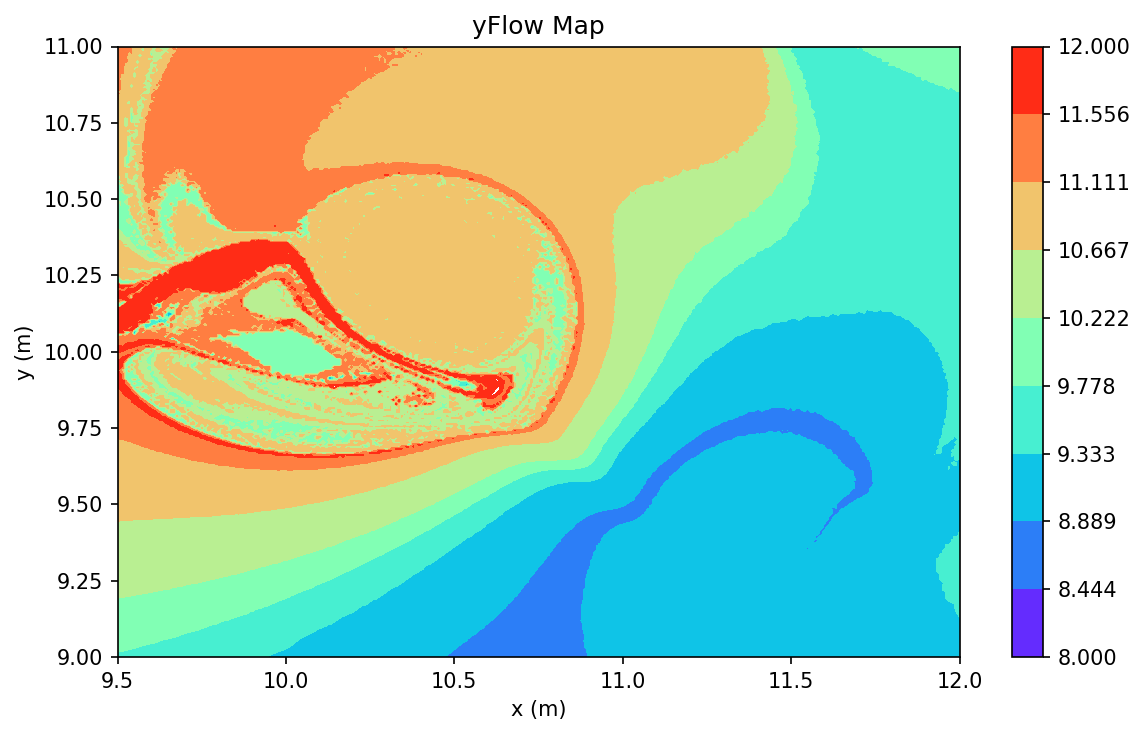

In [12]:
# This is an x flowmap
fig, ax = subplots(figsize=(8,5), dpi=150)
levels = range(9.5, 25, length=10)
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],particles[1,end,:,:],cmap=ColorMap("rainbow"),levels=levels)
fig.colorbar(cm)
ax.set_title(" xFlow Map ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

# This is an y flowmap
fig, ax = subplots(figsize=(8,5), dpi=150)
levels = range(8, 12, length=10)
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],particles[2,end,:,:],cmap=ColorMap("rainbow"),levels=levels)
fig.colorbar(cm)
ax.set_title(" yFlow Map ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()


Now let's calculate the FTLE value for each particle to get the FTLE field. For a forward moving time integration this would correspond to the largest stretching of the particle. 
On the other hand, a backward moving time integration would correspond to the largest compressing of the particle (in normal forward time).

In [13]:
for ii in 2:nx-1
    for jj in 2:ny-1
        ul = (particles[1,end,ii+1,jj]-particles[1,end,ii-1,jj])/(particles[1,1,ii+1,jj]-particles[1,1,ii-1,jj])
        ur = (particles[2,end,ii+1,jj]-particles[2,end,ii-1,jj])/(particles[2,1,ii,jj+1]-particles[2,1,ii,jj-1])
        ll = (particles[1,end,ii,jj+1]-particles[1,end,ii,jj-1])/(particles[1,1,ii+1,jj]-particles[1,1,ii-1,jj])
        lr = (particles[2,end,ii,jj+1]-particles[2,end,ii,jj-1])/(particles[2,1,ii,jj+1]-particles[2,1,ii,jj-1])
        B = [ul ur; ll lr]
        A = transpose(B) * B
        G = eigvals(A)
        H = ones(length(G))
        for i in 1:length(H)
            H[i] = abs(G[i])
        end
        sigma = maximum(H)
        particles[3,end,ii,jj] = 0.5/tstep_delta*log(sigma)
    end
end

Now let's plot the FTLE field that we just calculated.

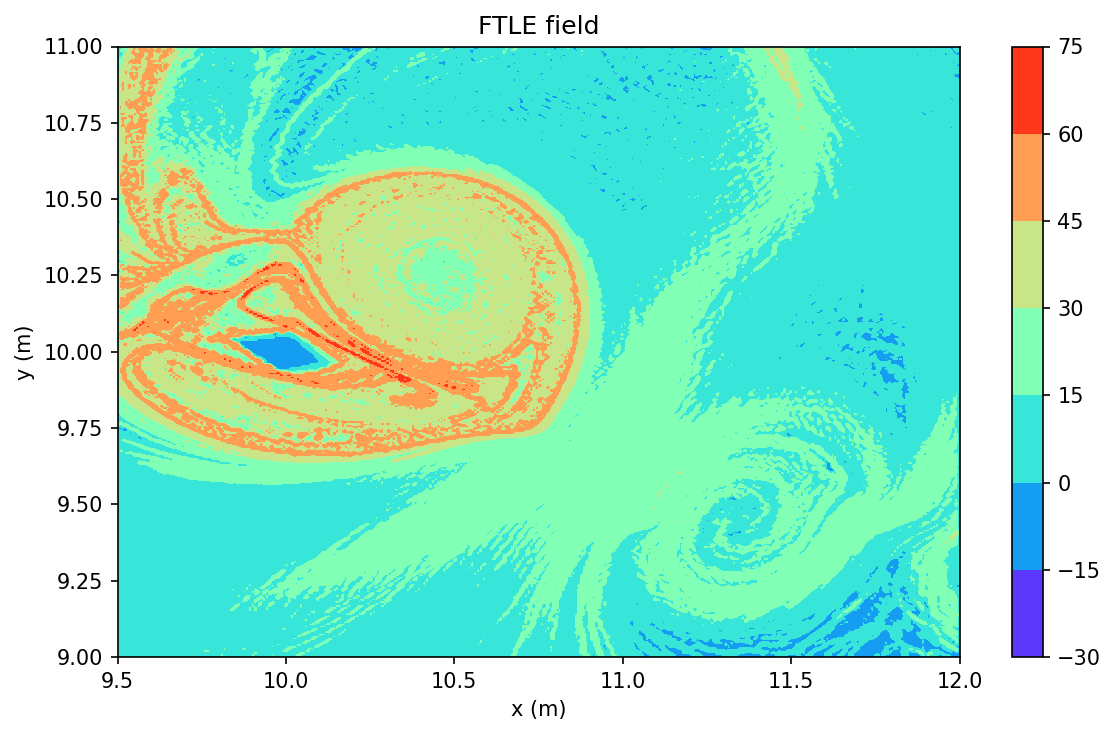

In [14]:
fig, ax = subplots(figsize=(8,5), dpi=150)
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],particles[3,end,:,:],cmap=ColorMap("rainbow"))
fig.colorbar(cm)
ax.set_title(" FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

Right now, the FTLE field doesn't look too visually pleasing. We will then do some post processing in order to get the desired look. This will inlcude some smoothing then thresholding in order to highlight only the areas with high FTLE value. 

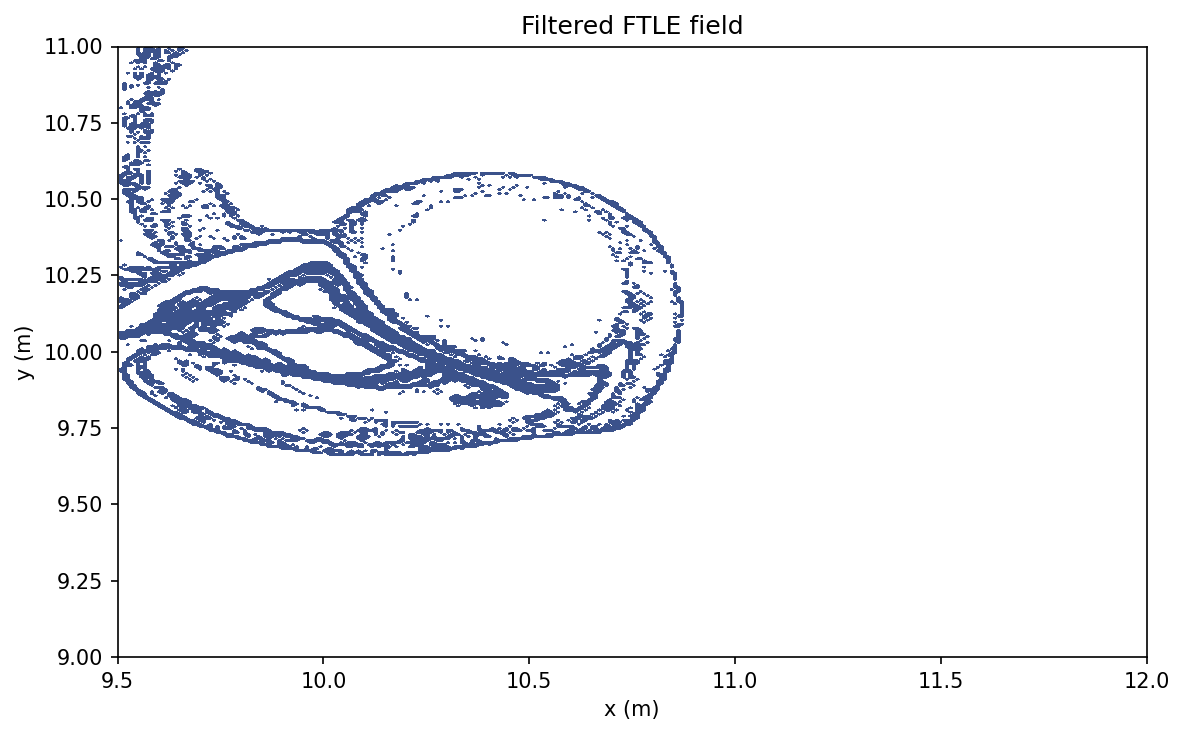

In [31]:

post = (particles[3,end,:,:] .> 0.7 * maximum(particles[3,end,:,:])) .|> Int
fig, ax = subplots(figsize=(8,5), dpi=150)
levels = range(0, 1,length=3) .+ 0.5
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],post,levels=levels)
ax.set_title(" Filtered FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

In [18]:
using ImageFiltering
print("DONE")

DONE

(300, 300)
(9, 9)
(300, 300)


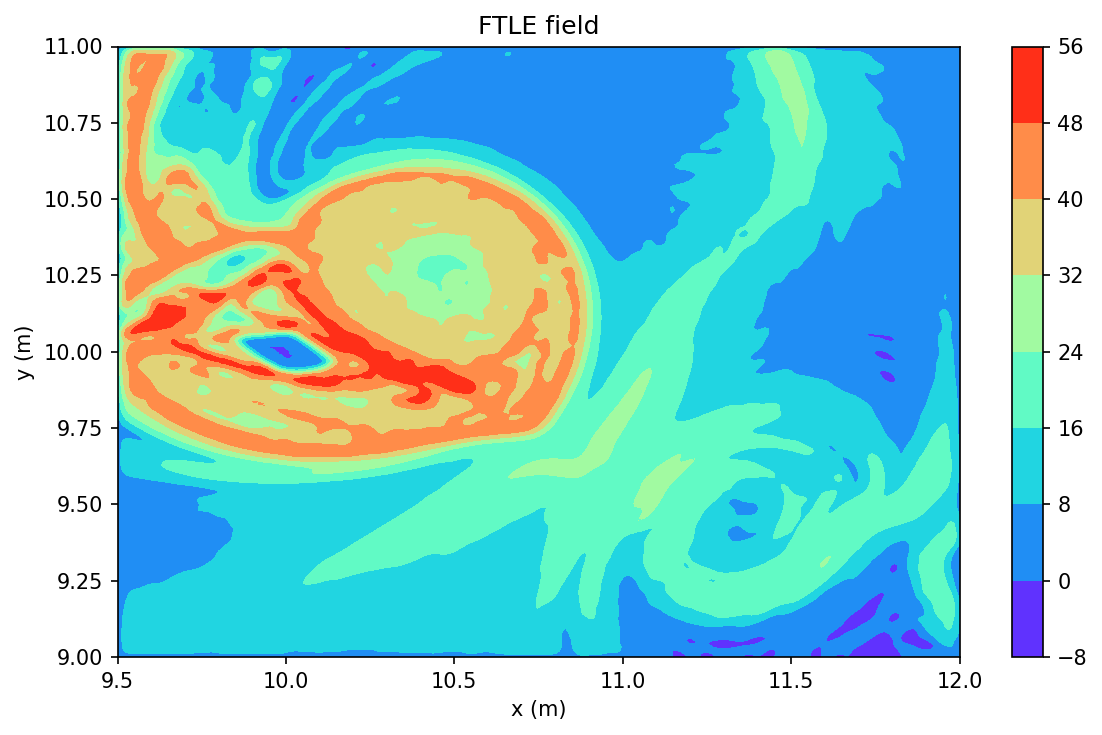

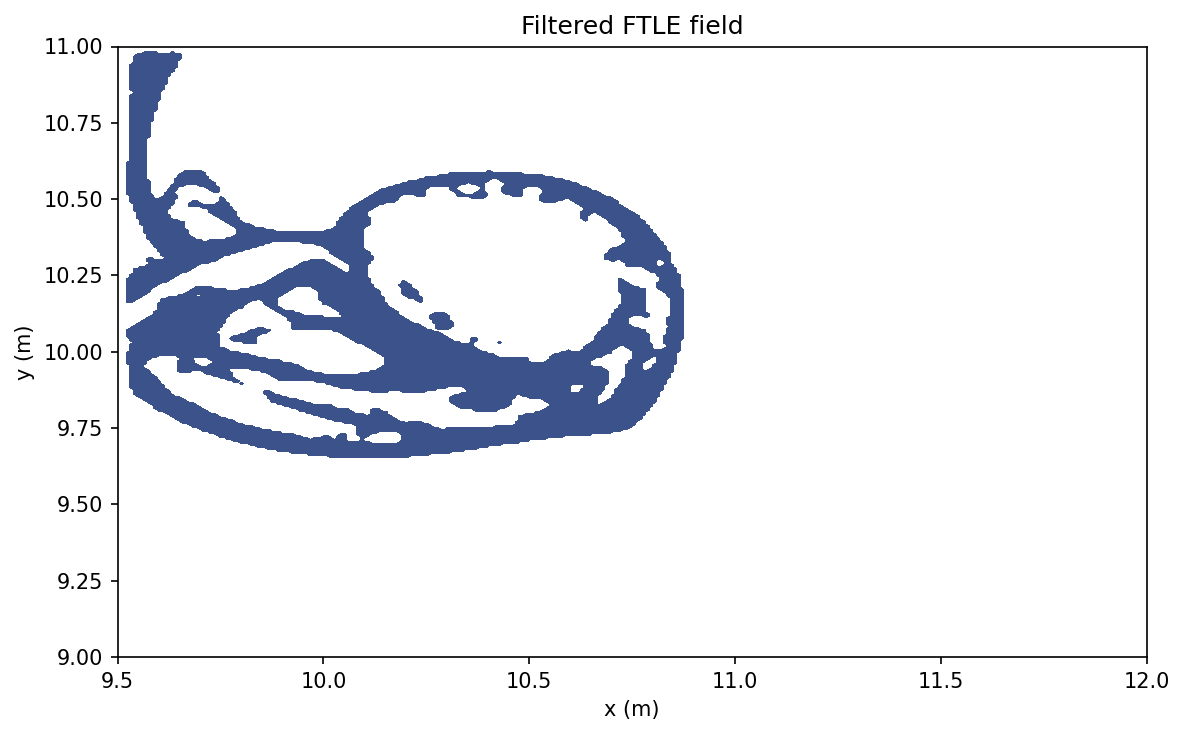

In [32]:
ending = particles[3,end,:,:]
println(size(ending))
ker = ImageFiltering.Kernel.gaussian(2)
println(size(ker))
filtered = ImageFiltering.imfilter(ending, ker)
println(size(filtered))

fig, ax = subplots(figsize=(8,5), dpi=150)
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],filtered,cmap=ColorMap("rainbow"))
fig.colorbar(cm)
ax.set_title(" FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

post = (filtered .> 0.7 * maximum(filtered)) .|> Int
fig, ax = subplots(figsize=(8,5), dpi=150)
levels = range(0, 1,length=3) .+ 0.5
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],post,levels=levels)
ax.set_title(" Filtered FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

Let's combine this to a full function and repeat the same thing for the negative FTLE.

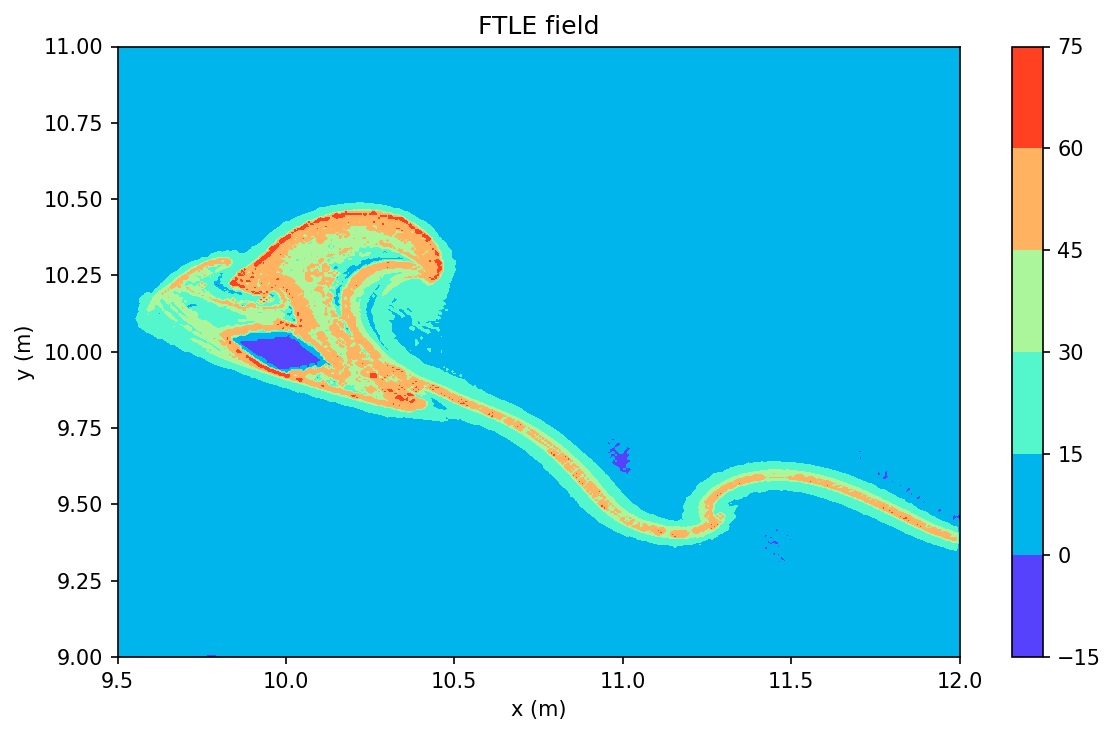

In [22]:
dt = -9000/1000
t1 = t0 + dt
move = Int64(sign(t1-t0))
t0_ind = Int64(argmin(abs.(tstep_range .- t0)))
t1_ind = Int64(argmin(abs.(tstep_range .- t1)))
tsteps = Int64(round(abs(t1 - t0)/(100/1000) + 1))

nx = 300
ny = 300
x0, x1, y0, y1 = 9.5,12.0,9.0,11.0
x = collect(range(x0, x1, length=nx))
y = collect(range(y0, y1, length=ny))
particles2 = zeros(3, tsteps+1, nx, ny)
for tt in 1:tsteps
    for ii in 1:nx
        for jj in 1:ny
            # Initialize the particles into the flow field
            particles2[1,tt,ii,jj] = x[ii]
            particles2[2,tt,ii,jj] = y[jj]
        end
    end
end
x = x_range
y = y_range
tstep_delta = 100/1000
# Integrate using Runge-Kutta 4th Order Method
for tt in t0_ind:move:t1_ind
    for ii in 1:nx
        for jj in 1:ny
            # Let's use Runge Kutta 4th order
            kxy = zeros(4,2)
            a = particles2[1,Int64(move*(tt-t0_ind)+1),ii,jj]
            b = particles2[2,Int64(move*(tt-t0_ind)+1),ii,jj]
            #=Runge Kutta 4th Order K1 =#
            c = copy(a)
            d = copy(b)
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[1,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt,y1,x1] + 
                            (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt,y2,x1] +
                            (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt,y1,x2] +
                            (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt,y2,x2] )
            end
            #=Runge Kutta 4th Order K2 =#
            c = a + 0.5*kxy[1,1]*tstep_delta
            d = b + 0.5*kxy[1,2]*tstep_delta
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[2,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                            (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                            (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                            (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
            end
            #=Runge Kutta 4th Order K3 =#
            c = a + 0.5*kxy[2,1]*tstep_delta
            d = b + 0.5*kxy[2,2]*tstep_delta
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[3,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                            (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                            (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                            (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
            end
            #=Runge Kutta 4th Order K4 =#
            c = a + kxy[3,1]*tstep_delta
            d = b + kxy[3,2]*tstep_delta
            x1, x2, y1, y2 = find_me(c, d)
            for UV in 1:2
                kxy[4,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                            (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt+move,y1,x1] + 
                            (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt+move,y2,x1] +
                            (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt+move,y1,x2] +
                            (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt+move,y2,x2] )
            end
            for UV in 1:2
                particles2[UV,Int64(move*(tt-t0_ind)+2),ii,jj] = particles2[UV,Int64(move*(tt-t0_ind)+1),ii,jj] + sign(move)*(kxy[1,UV]+2*kxy[2,UV]+2*kxy[3,UV]+kxy[4,UV])*tstep_delta/6
            end
        end
    end
end
for ii in 2:nx-1
    for jj in 2:ny-1
        ul = (particles2[1,end,ii+1,jj]-particles2[1,end,ii-1,jj])/(particles2[1,1,ii+1,jj]-particles2[1,1,ii-1,jj])
        ur = (particles2[2,end,ii+1,jj]-particles2[2,end,ii-1,jj])/(particles2[2,1,ii,jj+1]-particles2[2,1,ii,jj-1])
        ll = (particles2[1,end,ii,jj+1]-particles2[1,end,ii,jj-1])/(particles2[1,1,ii+1,jj]-particles2[1,1,ii-1,jj])
        lr = (particles2[2,end,ii,jj+1]-particles2[2,end,ii,jj-1])/(particles2[2,1,ii,jj+1]-particles2[2,1,ii,jj-1])
        B = [ul ur; ll lr]
        A = transpose(B) * B
        G = eigvals(A)
        H = ones(length(G))
        for i in 1:length(H)
            H[i] = abs(G[i])
        end
        sigma = maximum(H)
        particles2[3,end,ii,jj] = 0.5/tstep_delta*log(sigma)
    end
end
fig, ax = subplots(figsize=(8,5), dpi=150)
cm = ax.contourf(particles2[1,1,:,:],particles2[2,1,:,:],particles2[3,end,:,:],cmap=ColorMap("rainbow"))
fig.colorbar(cm)
ax.set_title(" FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

In [23]:
ending = particles2[3,end,:,:]
println(size(ending))
ker = ImageFiltering.Kernel.gaussian(3)
println(size(ker))
filtered2 = ImageFiltering.imfilter(ending, ker)
println(size(filtered))

(300, 300)
(13, 13)
(300, 300)


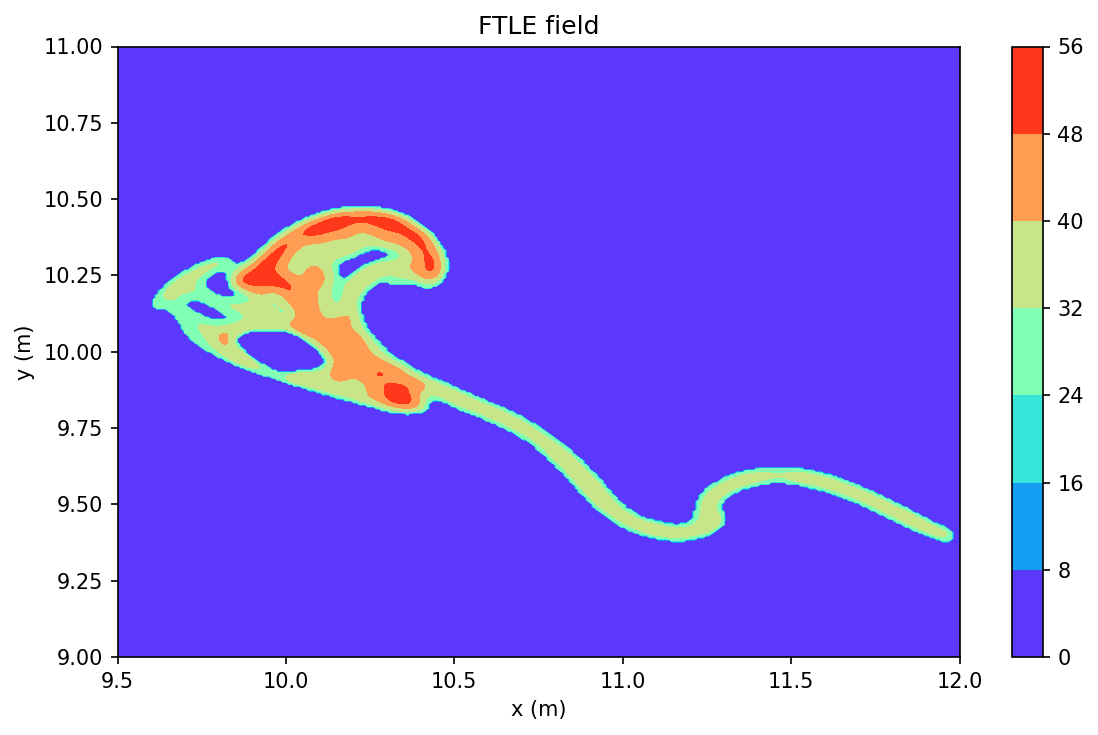

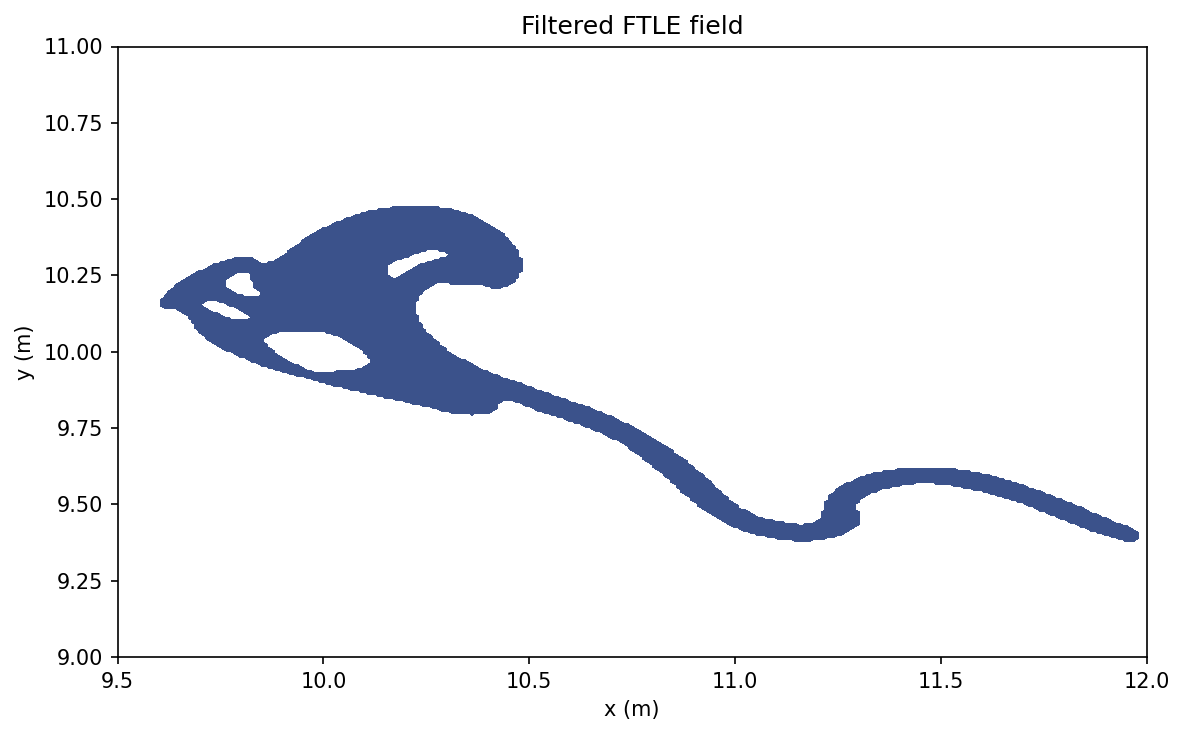

In [33]:
fig, ax = subplots(figsize=(8,5), dpi=150)
cm = ax.contourf(particles2[1,1,:,:],particles2[2,1,:,:],filtered2,cmap=ColorMap("rainbow"))
fig.colorbar(cm)
ax.set_title(" FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()
post2 = (filtered2 .> 0.5 * maximum(filtered2)) .|> Int
fig, ax = subplots(figsize=(8,5), dpi=150)
levels = range(0, 1,length=3) .+ 0.5
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],post2,levels=levels)
ax.set_title(" Filtered FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

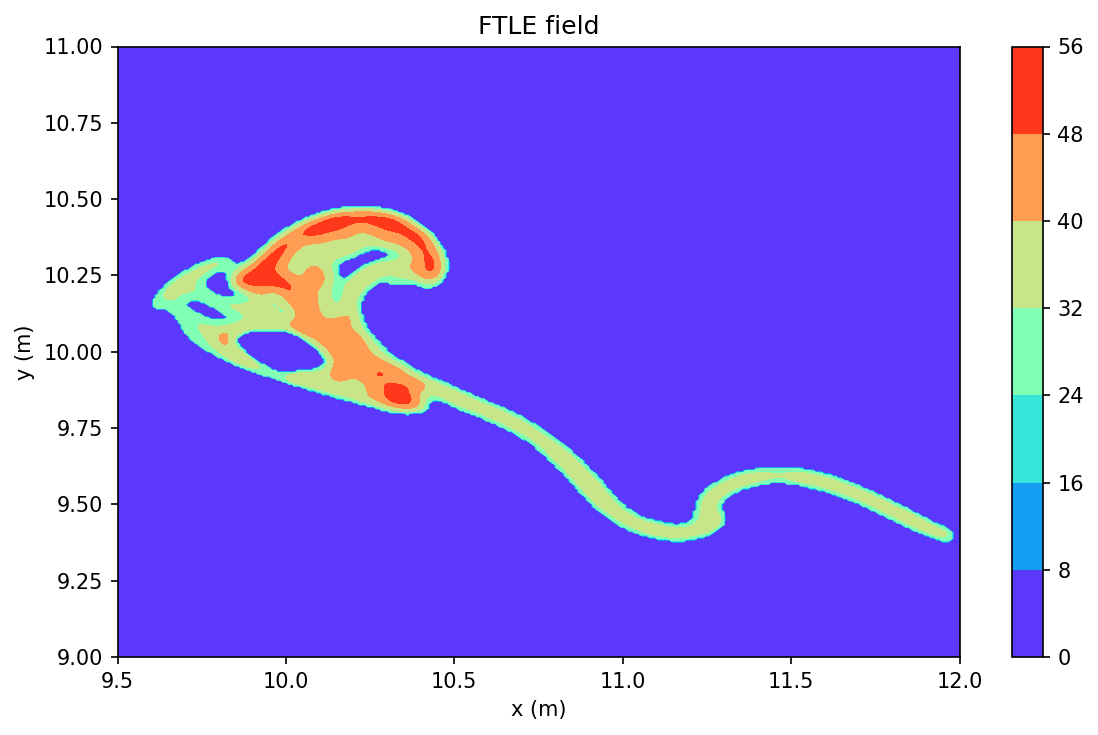

In [28]:
#manifolds = (field[3,:,:,:] .> limFTLE * maximum(field[3,:,:,:])) .|> Int
filtered2 = [x < 0.5*maximum(filtered) ? 0 : x for x in filtered]
fig, ax = subplots(figsize=(8,5), dpi=150)
cm = ax.contourf(particles2[1,1,:,:],particles2[2,1,:,:],filtered2,cmap=ColorMap("rainbow"))
fig.colorbar(cm)
ax.set_title(" FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

In [ ]:
fig, ax = subplots(figsize=(8,5), dpi=150)
levels = range(0, 1,length=3) .+ 0.5
cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],post,levels=levels)
ax.set_title(" Filtered FTLE field ")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
fig.tight_layout()

cm = ax.contourf(particles[1,1,:,:],particles[2,1,:,:],post2,levels=levels)

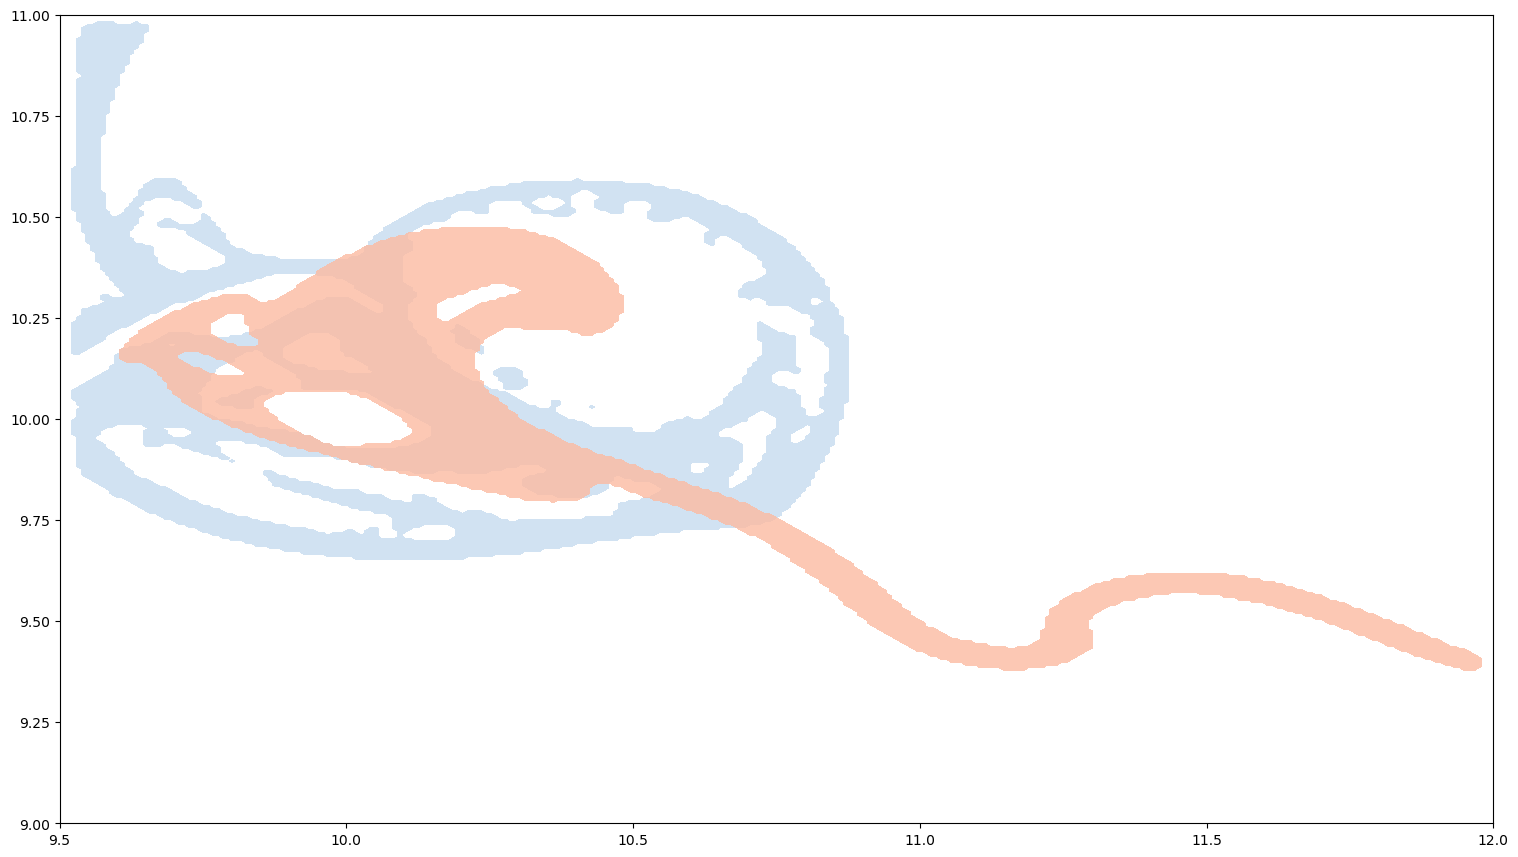

PyObject <matplotlib.contour.QuadContourSet object at 0x0000026493FCFB80>

In [34]:
x = particles[1,1,:,:]
y = particles[2,1,:,:]
fig, ax = subplots(figsize=(18.5,10.5))
levels = range(0, 1,length=3) .+ 0.5
ax.contourf(x,y,post,cmap=ColorMap("Blues"),levels=levels, alpha=0.8, zorder=1)
ax.contourf(x,y,post2,cmap=ColorMap("Reds") ,levels=levels, alpha=0.8, zorder=2)